In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

# Loading in Dataset

In [10]:
import yfinance as yf
dataframe = yf.download("AAPL", start="2000-01-01", end="2021-07-01")
dataframe


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,0.901228,0.918527,0.888393,0.917969,0.789364,163811200
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.859423,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.786965,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.798481,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.729382,767972800
...,...,...,...,...,...,...
2021-06-24,134.449997,134.639999,132.929993,133.410004,133.410004,68711000
2021-06-25,133.460007,133.889999,132.809998,133.110001,133.110001,70783700
2021-06-28,133.410004,135.250000,133.350006,134.779999,134.779999,62111300


In [13]:
dataframe.reset_index(inplace=True)
dataframe.rename(lambda x: x.strip('*').replace(' ', '_').lower(), axis='columns', inplace=True)
dataframe

,date,open,high,low,close,adj_close,volume
0,1999-12-31,0.901228,0.918527,0.888393,0.917969,0.789364,163811200
1,2000-01-03,0.936384,1.004464,0.907924,0.999442,0.859423,535796800
2,2000-01-04,0.966518,0.987723,0.903460,0.915179,0.786965,512377600
3,2000-01-05,0.926339,0.987165,0.919643,0.928571,0.798481,778321600
4,2000-01-06,0.947545,0.955357,0.848214,0.848214,0.729382,767972800
...,...,...,...,...,...,...,...
5404,2021-06-24,134.449997,134.639999,132.929993,133.410004,133.410004,68711000
5405,2021-06-25,133.460007,133.889999,132.809998,133.110001,133.110001,70783700
5406,2021-06-28,133.410004,135.250000,133.350006,134.779999,134.779999,62111300
5407,2021-06-29,134.800003,136.490005,134.350006,136.330002,136.330002,64556100


# Preprocessing and feature extraction

In [14]:
dataframe = dataframe['open'].values
dataframe 

array([  0.90122801,   0.93638402,   0.96651798, ..., 133.41000366,
       134.80000305, 136.16999817])

In [16]:
dataframe = dataframe.reshape(-1,1)
dataframe.shape
dataframe[:5]

array([[0.90122801],
       [0.93638402],
       [0.96651798],
       [0.92633897],
       [0.94754499]])

In [18]:
dataset_train = np.array(dataframe[:int(dataframe.shape[0]*0.8)])
dataset_test = np.array(dataframe[int(dataframe.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

(4327, 1)
(1132, 1)


In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:3]

array([[0.0192494 ],
       [0.02026056],
       [0.02112728]])

In [22]:
dataset_test = scaler.fit_transform(dataset_test)
dataset_test[:5]

array([[0.00185346],
       [0.        ],
       [0.00010902],
       [0.00026166],
       [0.00213693]])

In [23]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [24]:
x_train, y_train = create_dataset(dataset_train)
print(x_train[:1])
print(y_train[:1])

[[0.0192494  0.02026056 0.02112728 0.01997165 0.02058158 0.01810982
  0.01952224 0.01796538 0.01772461 0.01759219 0.01900864 0.01926545
  0.02045315 0.0229891  0.02266809 0.02117543 0.02029266 0.02157669
  0.02127172 0.02111123 0.01926545 0.02003584 0.01920126 0.01908888
  0.0200198  0.02106308 0.02260389 0.02263599 0.02231501 0.0225076
  0.02140012 0.02292491 0.02356691 0.02290886 0.02276441 0.02160879
  0.02240728 0.02345456 0.02281256 0.02160879 0.02249155 0.02377557
  0.02594236 0.02539663 0.02568555 0.02579789 0.02488303 0.02436942
  0.02457809 0.02469044]]
[0.02445769]


In [25]:
x_test, y_test = create_dataset(dataset_test)
print(x_test[:1])

[[0.00185346 0.         0.00010902 0.00026166 0.00213693 0.00468817
  0.00647622 0.0064108  0.0067597  0.00721761 0.00553858 0.0091583
  0.00784997 0.01013954 0.0091583  0.00817706 0.01007413 0.01279981
  0.01382468 0.01118621 0.01166594 0.02448756 0.02655909 0.02727866
  0.02906673 0.03214128 0.03390755 0.03456169 0.03632796 0.03767989
  0.0385303  0.04300044 0.04332751 0.04208461 0.04454861 0.04498471
  0.04705626 0.04385085 0.04653292 0.04640209 0.04816833 0.05276929
  0.05010902 0.05139553 0.05071957 0.05047971 0.05002181 0.05113388
  0.05026167 0.05124291]]


In [43]:
# Reshape features for LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Build model

In [44]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [45]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [48]:
model.fit(x=x_train, y=y_train, epochs=50, batch_size=32, verbose=2)
model.save('rnn_stock_prediction.h5')

Epoch 1/50
134/134 - 28s - loss: 4.6856e-04
Epoch 2/50
134/134 - 22s - loss: 5.4589e-04
Epoch 3/50
134/134 - 24s - loss: 4.6618e-04
Epoch 4/50
134/134 - 27s - loss: 5.2847e-04
Epoch 5/50
134/134 - 30s - loss: 5.5519e-04
Epoch 6/50
134/134 - 25s - loss: 4.7509e-04
Epoch 7/50
134/134 - 21s - loss: 4.8793e-04
Epoch 8/50
134/134 - 24s - loss: 4.6309e-04
Epoch 9/50
134/134 - 21s - loss: 4.8337e-04
Epoch 10/50
134/134 - 18s - loss: 5.5354e-04
Epoch 11/50
134/134 - 18s - loss: 4.6662e-04
Epoch 12/50
134/134 - 20s - loss: 5.0558e-04
Epoch 13/50
134/134 - 20s - loss: 4.6190e-04
Epoch 14/50
134/134 - 17s - loss: 4.9202e-04
Epoch 15/50
134/134 - 22s - loss: 4.5771e-04
Epoch 16/50
134/134 - 20s - loss: 4.6329e-04
Epoch 17/50
134/134 - 19s - loss: 4.6376e-04
Epoch 18/50
134/134 - 28s - loss: 4.7333e-04
Epoch 19/50
134/134 - 23s - loss: 4.7370e-04
Epoch 20/50
134/134 - 21s - loss: 4.5906e-04
Epoch 21/50
134/134 - 21s - loss: 4.8570e-04
Epoch 22/50
134/134 - 24s - loss: 4.6070e-04
Epoch 23/50
134/134

In [49]:
model = load_model('rnn_stock_prediction.h5')
model

# Visualizing results

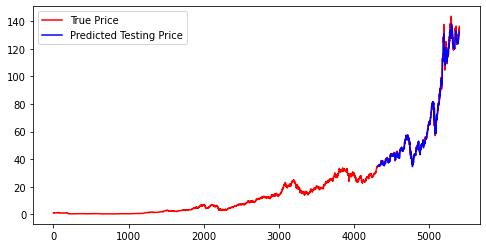

In [50]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(dataframe, color='red',  label="True Price")
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Testing Price')
plt.legend()

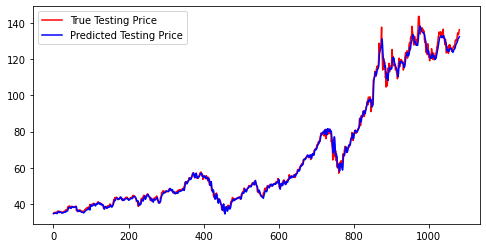

In [51]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label='True Testing Price')
plt.plot(predictions, color='blue', label='Predicted Testing Price')
plt.legend()